In [14]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from numba import jit,njit,prange
from numba.typed import List
import numba as nb

import scipy as sp
from scipy import io
from scipy import linalg
from scipy import stats

import networkx as nx

#---------------------------------------------------------------
# Symmetric matrix to lower triangle vector
def mat2lowtri(A):
    (N,N) = A.shape
    L = int(N*(N-1)/2)

    low_tri_indices = np.where(np.triu(np.ones((N,N)))-np.eye(N))
    a = A[low_tri_indices[1],low_tri_indices[0]]
    return a

#---------------------------------------------------------------
# Lower triangle vector to symmetric matrix
def lowtri2mat(a):
    L = len(a)
    N = int(.5 + np.sqrt(2*L + .25))

    A = np.full((N,N),0,dtype=type(a[0]))
    low_tri_indices = np.where(np.triu(np.ones((N,N)))-np.eye(N))
    A[low_tri_indices[1],low_tri_indices[0]] = a
    A += A.T
    return A


#---------------------------------------------------------------
# Numba-friendly Kronecker product for matrices A and B
@jit(nopython=True)
def mykron(A,B):
    (ar,ac) = A.shape
    (br,bc) = B.shape
    C = np.zeros((ar*br,ac*bc))
    for i in range(ar):
        rjmp = i*br
        for k in range(br):
            irjmp = rjmp + k
            slice = B[k,:]
            for j in range(ac):
                cjmp = j*bc
                C[irjmp,cjmp:cjmp+bc] = A[i,j]*slice
    return C

# ------------------------------------------------------------------------------
# Sample graph from graphon
def graph_from_graphon(N,graphon_type='ER'):
    if graphon_type=='ER':
        edge_prob = .2
        G = np.array(nx.to_numpy_matrix(nx.generators.random_graphs.fast_gnp_random_graph(n=N,p=edge_prob)))
        G = G*np.tril((1-np.eye(N)))
        G += G.T
        return G
    elif graphon_type=='SBM':
        P = .9
        Q = .2
        SBM_mat = P*np.eye(2) + Q*(1-np.eye(2))
        # node_labels = np.concatenate((np.zeros(int(N/2)),np.ones(int(N/2)))).astype(int)
        node_labels = np.sort(np.random.binomial(1,.5,N))
        probmat = SBM_mat[node_labels.reshape(1,-1),node_labels.reshape(-1,1)]
        G = np.random.binomial(1,probmat)
        G = G*np.tril((1-np.eye(N)))
        G += G.T
        return G
    elif graphon_type=='quad':
        zeta = np.sort(np.random.random(N))
        Prob_mat = .5*(zeta.reshape(-1,1)**2+zeta.reshape(1,-1)**2)
        G = np.random.binomial(1,Prob_mat)
        G = G*np.tril((1-np.eye(N)))
        G += G.T
        return G
    elif graphon_type=='grid':
        k_grid=6
        G = np.array(nx.to_numpy_matrix(nx.generators.random_graphs.watts_strogatz_graph(n=N,k=k_grid,p=0)))
        G = G*np.tril((1-np.eye(N)))
        G += G.T
        return G
    elif graphon_type=='similarity':
        zeta = np.sort(np.random.random(N))
        Prob_mat = .8*np.exp(-2*np.abs(zeta.reshape(-1,1)-zeta.reshape(1,-1)))
        G = np.random.binomial(1,Prob_mat)
        G = G*np.tril((1-np.eye(N)))
        G += G.T
        return G
    else:
        print('Improper graphon type given.')

# ------------------------------------------------------------------------------
# Return graphon at given points
def graphon(x,y,graphon_fam='ER',p=None,p1=None,p0=None,gamma=None):
    if graphon_fam=='ER':
        if p==None:
            p = .5
        if (type(x) is float) and (type(y) is float):
            return p
        elif (type(x) is not float) and (type(y) is not float):
            return p*np.ones((x.shape[0]*y.shape[0],x.shape[1]*y.shape[1]))
        elif (type(x) is float) and (type(y) is not float):
            return p*np.ones(len(y))
        elif (type(x) is not float) and (type(y) is float):
            return p*np.ones(len(x))
    elif graphon_fam=='quad':
        if gamma==None:
            gamma = 1
        if p==None:
            p = 2
        return gamma*(x.reshape(-1,1)**p + y.reshape(1,-1)**p)/p + (1-gamma)
    elif graphon_fam=='SBM':
        if p1==None:
            p1=.75
        if p0==None:
            p0=1-p1
        return p1*(((x>.5)*(y>.5))+((x<=.5)*(y<=.5))) + \
               p0*(((x<=.5)*(y>.5))+((x>.5)*(y<=.5)))
    else:
        print('Please choose ER, quad, or SBM graphon type.')
        return None

#---------------------------------------------------------------
'''
Reference:
Chan, Stanley and Airoldi, Edoardo.
"A Consistent Histogram Estimator for Exchangeable Graph Models."
ICML, PMLR 32(1) (2014): 208-216.
'''
def graphon_from_sas(A,z=None,num_bins=5):
    (N,N) = A.shape
    if z is None:
        deg = np.sum(A,axis=0)
        ord_deg = np.argsort(deg)
        A = A[ord_deg,:][:,ord_deg]
        z = (deg[ord_deg]/max(deg+1))

    num_bins = int(np.minimum(N,num_bins))
    F = np.kron(np.eye(num_bins),np.ones((int(np.ceil(N/num_bins)),int(np.ceil(N/num_bins))))-np.eye(int(np.ceil(N/num_bins))))[:N,:N]
    F[np.sum(F,axis=0)>0,:]/=(np.sum(F,axis=0)[np.sum(F,axis=0)>0]).reshape(-1,1)

    sbm = F@A@F.T
    return sbm




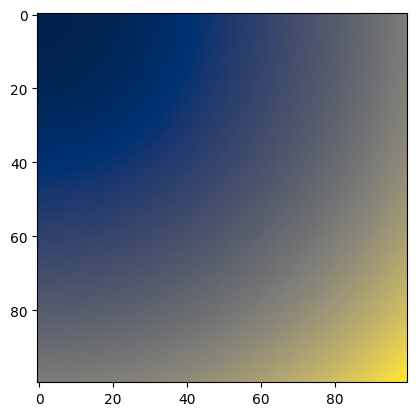

In [15]:
# Example of quadratic graphon

u = np.linspace(0,1,100)
W_at_latent_points = graphon(u.reshape(-1,1),u.reshape(1,-1),graphon_fam='quad')

plt.figure()
plt.imshow(W_at_latent_points,'cividis',vmin=0,vmax=1)

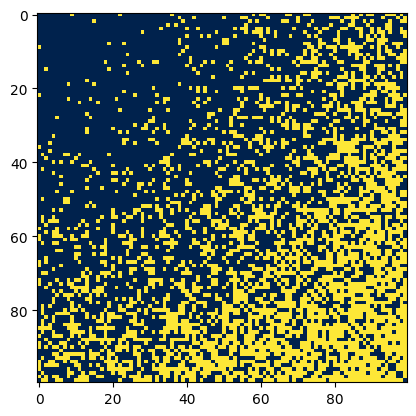

In [27]:
# To sample graph from graphon, decide size and assign latent points between 0 and 1 to each node
# I sort the latent points (zeta) here for the figure. You would not do this for traditional graphon sampling

N = 100
zeta = np.sort(np.random.random(N))
prob_mat = graphon(zeta.reshape(-1,1),zeta.reshape(1,-1),graphon_fam='quad')
A = np.random.binomial(1,prob_mat)
A[np.tril_indices(N)] = 0
A+=A.T

plt.figure()
plt.imshow(A,'cividis')


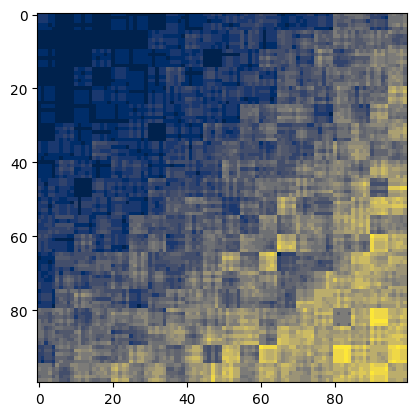

In [29]:
W_est = graphon_from_sas(A,num_bins=20)

plt.figure()
plt.imshow(W_est,'cividis',vmin=0,vmax=1)